In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

### Inputs

In [2]:
PATH = "/kaggle/input/dogs-cats-images/dataset/"
TRAIN_DIR = "training_set/"
TEST_DIR = "test_set/"

SEED=0
NUM_WORKERS=2
BATCH_SIZE=64
TRAIN_SET_SIZE = 8000
VALID_SET_SIZE = 1500
TEST_SET_SIZE = 500

torch.manual_seed(0)
np.random.seed(0)

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])

train_set = torchvision.datasets.ImageFolder(PATH + TRAIN_DIR, transform=train_transforms)
valid_test_set = torchvision.datasets.ImageFolder(PATH + TEST_DIR, transform=test_transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

valid_set, test_set = torch.utils.data.random_split(valid_test_set, (VALID_SET_SIZE, TEST_SET_SIZE))
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=TEST_SET_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [5]:
images, labels = next(iter(train_loader))

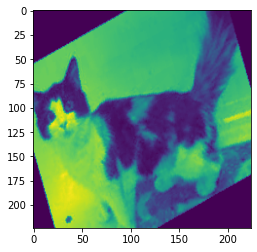

cat


In [6]:
idx = np.random.randint(0, 32)
plt.imshow(images[idx][0])
plt.show()
print("cat" if labels[idx]==0 else "dog")

### Architecture

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=4)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(576, 2)
        
        self.bc1 = nn.BatchNorm2d(16)
        self.bc2 = nn.BatchNorm2d(64)
        self.do1 = nn.Dropout(0.2)
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.bc1(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = self.bc2(F.max_pool2d(F.relu(self.conv4(x)), 2))
        x = torch.flatten(x, start_dim=-3)
        x = self.do1(self.fc1(x))
        
        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = Classifier().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0003)

In [10]:
def train():
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = net(images)
        loss = F.cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss/TRAIN_SET_SIZE

def evaluate(data_loader = valid_loader, data_set_len = VALID_SET_SIZE):
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        preds = net(images)
        loss = F.cross_entropy(preds, labels)
        total_loss += loss.item()
    
    return total_loss/data_set_len

def calculate_accuracy(preds, labels):
    return preds.argmax(-1).eq(labels).sum().item()

def get_all_accuracies(data_loader, data_set_len):
    total_acc = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        preds = net(images)
        total_acc += calculate_accuracy(preds, labels)
    
    return total_acc/data_set_len

def view_loss_grap():
    plt.title("Loss")
    plt.plot(train_loss_list, label="train")
    plt.plot(valid_loss_list, label="valid")
    plt.legend()
    plt.show()

def view_acc_grap():
    plt.title("Accuracy")
    plt.plot(train_acc_list, label="train")
    plt.plot(valid_acc_list, label="valid")
    plt.legend()
    plt.show()

In [11]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
test_loss_list = []
test_acc_list = []

In [22]:
for e in range(30):
    net.train()
    train_loss_list.append(train())
    with torch.no_grad():
        net.eval()
        valid_loss_list.append(evaluate())
        valid_acc_list.append(get_all_accuracies(valid_loader, VALID_SET_SIZE))
        train_acc_list.append(get_all_accuracies(train_loader, TRAIN_SET_SIZE))
    
    print("E:",e," tl:",train_loss_list[-1]," | vl:",valid_loss_list[-1]," | tc:",train_acc_list[-1]," | vc:",valid_acc_list[-1])

E: 0  tl: 0.004646629871800542  | vl: 0.0059960154791673026  | tc: 0.883625  | vc: 0.844
E: 1  tl: 0.004612324172630906  | vl: 0.005675669590632121  | tc: 0.885125  | vc: 0.8353333333333334
E: 2  tl: 0.004731699042022228  | vl: 0.0054633730451265974  | tc: 0.884  | vc: 0.8513333333333334
E: 3  tl: 0.004562083465978503  | vl: 0.005405369997024536  | tc: 0.89725  | vc: 0.8546666666666667
E: 4  tl: 0.0044594394452869895  | vl: 0.005661382406949997  | tc: 0.87825  | vc: 0.8346666666666667
E: 5  tl: 0.004479846581816673  | vl: 0.005627949327230454  | tc: 0.8975  | vc: 0.8486666666666667
E: 6  tl: 0.004374123457819223  | vl: 0.00625975168744723  | tc: 0.8665  | vc: 0.832
E: 7  tl: 0.004384104341268539  | vl: 0.005712292015552521  | tc: 0.887  | vc: 0.854
E: 8  tl: 0.004619584711268544  | vl: 0.005517758826414744  | tc: 0.88775  | vc: 0.8486666666666667
E: 9  tl: 0.004362158983945846  | vl: 0.005494072596232097  | tc: 0.8905  | vc: 0.848
E: 10  tl: 0.004622810497879982  | vl: 0.00602568652232

Test Loss: 0.0006812727451324463
Test Acc: 0.864


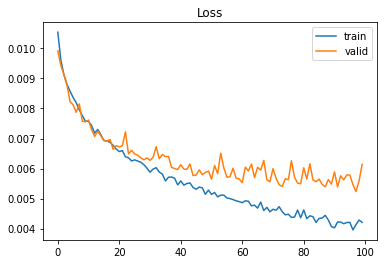

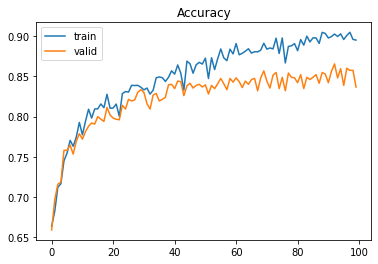

In [23]:
with torch.no_grad():
    net.eval()
    test_loss_list.append(evaluate(data_loader = test_loader, data_set_len = TEST_SET_SIZE))
    test_acc_list.append(get_all_accuracies(test_loader, TEST_SET_SIZE))
    print("Test Loss:",test_loss_list[-1])
    print("Test Acc:",test_acc_list[-1])
    view_loss_grap()
    view_acc_grap()

In [24]:
model_path = "model-100-epochs-adam-0003-lr-cpu.pth"
torch.save(net.state_dict(), model_path)